In [32]:

#########################################################################################################################
## PROJECT : Dimension Reduction for Distributions 
## TITLE : First version of density estimation for 1d/2d dimensional distributions (Algorithm 2 and 3)
## AUTHOR : Laurène David 
## DATE : 21/02/2023
#########################################################################################################################



In [33]:
import time
start_time = time.time()


In [34]:
print("     ") 
print("01 Import Libraries")
print("     ") 

     
01 Import Libraries
     


In [35]:
######################################################################################
## IMPORT LIBRARIES
######################################################################################

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import dirichlet 

In [36]:
print("     ") 
print("02 GENERATE DATA WITH MULTIVARIATE NORMAL DISTRIBUTION ")
print("     ") 

     
02 GENERATE DATA WITH MULTIVARIATE NORMAL DISTRIBUTION 
     


In [37]:
######################################################################################
## GENERATE DATA WITH MULTIVARIATE NORMAL DISTRIBUTION 
######################################################################################

mean = [0,0] # mean vector 
cov = [[1, 0], [0, 1]] # covariance matrix 
# X = np.random.multivariate_normal(mean, cov, 5000) 


In [38]:
print("     ") 
print("03 GENERATE DATA WITH MULTIVARIATE BETA DISTRIBUTION (DIRICHLET)")
print("     ") 

     
03 GENERATE DATA WITH MULTIVARIATE BETA DISTRIBUTION (DIRICHLET)
     


In [39]:

######################################################################################
## GENERATE DATA WITH MULTIVARIATE BETA DISTRIBUTION (DIRICHLET)
######################################################################################

X = dirichlet.rvs([1,3], size=50000, random_state=1)


In [40]:
print('Printing the multivariate distribution: ',X)

Printing the multivariate distribution:  [[0.25706334 0.74293666]
 [0.09348114 0.90651886]
 [0.57756    0.42244   ]
 ...
 [0.19341246 0.80658754]
 [0.22791794 0.77208206]
 [0.18638568 0.81361432]]


In [41]:
######################################################################################
## ALGORITHM 1 : ESTIMATE PROBABILITY MATRIX FOR DISCRETE DISTRIBUTIONS
######################################################################################
# I need Algorithm 1 to execute Algorithm 2

def our_algo(n,Y1,Y2,alpha,cstar,Cbar):

    """
    This function implements a low-rank probability matrix estimation for discrete distributions.

    
    Parameters :
    -----

    n : int
    sample size 

    Y1 : numpy.ndarray
    a 2-dimensional histogram with shape (d1,d2)
    d1 is the number of labels in the first variable, d2 in the second variable
    
    Y2 : numpy.ndarray 
    a 2-dimensional histogram with shape (d1,d2) representing an empirical estimator of the probability matrix

    alpha : int (alpha > 0)
    a constant 

    cstar : int (cstar > 0)
    a constant (from Proposition 5)

    Cbar : int (Cbar > 0)
    an absolute constant (from Lemma 1)

    
    
    Return :
    ----
    res/np.sum(res) : numpy.ndarray
    an estimation of the discrete matrix probability


    """ 

    (d1,d2) = np.shape(Y1)
    d = max(d1,d2)
    
    if (n <= d*np.log(d)):
        return((Y1+Y2)/2)
      
    else:
        res = np.zeros((d1,d2))
        T = int(np.log(d)/np.log(2))
        p = np.sum(Y1, axis=1)
        q = np.sum(Y1, axis=0)

        for t in range(T+1):
            if (t<T):
                I = np.argwhere((p <= 2**(-t)) & (p > 2**(-t-1)))
            else: 
                I = np.argwhere((p <= 2**(-t)))
                
            for u in range(T+1):
                if (u<T):
                    J = np.argwhere((q <= 2**(-u)) & (q > 2**(-u-1)))
                else: 
                    J = np.argwhere(q <= 2**(-u))

                M = np.zeros((len(I),len(J)))


                for i in range(len(I)):
                    for j in range(len(J)):
                        M[i,j] = Y2[I[i],J[j]]
                
                if (np.sum(M) < 2*Cbar*alpha*np.log(d)/(n*np.log(2))):
                    for i in range(len(I)):
                        for j in range(len(J)):
                            res[I[i],J[j]] = Y2[I[i],J[j]]
                
                else:
                    tau = np.log(d) * np.sqrt(cstar * 2**(1-min(t,u))/n)
                    U,s,Vh = np.linalg.svd(M)
                    l = len(s[s>=tau])  

                    H = np.dot(U[:,:l]*s[:l], Vh[:l,:])
                    for i in range(len(I)):
                        for j in range(len(J)):
                            res[I[i],J[j]] = H[i,j]
        
        return(res/np.sum(res))



In [42]:

#####################################################################################
## ALGORITHM 3 : ONE-DIMENSIONAL DENSITY ESTIMATION PROCEDURE 
######################################################################################

# My attempt to implement the paper's third algorithm. 
 

def our_algo_3(n,Z,L):
    """
    This function returns a density estimator for univariate continuous distributions.

    
    Parameters :
    ----

    n : int 
    sample size 

    Z : ndarray of shape (n,)
    A 1d array generated by a density function for continuous distributions

    L : int (L > 0)
    a constant 

    C : float 
    a large absolute constant


    Return :
    ---
    f_1(x) : density function estimator for univariate distributions 
    with x as a 1-dimensional array
    
    """
    
    r = np.min(Z)
    R = np.max(Z)

    if (R - r < n**(-1/3)*L**(-1/2)):
        return lambda x : 1/(R-r) if (x<=r and x>=R) else 0

    else:
        def f_1(x):
            s = 0
            N = np.zeros((int(1/h),))
            
            for j in range(int(1/h)):
                a = j*h
                b = (j+1)*h
                N[j] = len(np.argwhere((Z>=a) & (Z<b)))
                
                if (x>=j*h) and (x<=(j+1)*h):
                    s += N[j]
    
            return (1/h)*s
        
        return f_1


In [43]:


#######################################################################################
## ALGORITHM 2 : TWO-DIMENSIONAL DENSITY ESTIMATION PROCEDURE
#######################################################################################


def our_algo_2(n,X,alpha,L,C,Cbar,cstar):

    """
    This function returns a probability density estimator for bivariate continuous distributions.


    Parameters :
    ----

    n : int 
    sample size 

    X : np.array of shape (n,2)
    a numpy array generated by a joint continuous distribution 
    
    alpha : float (alpha > 0)
    a constant 

    L : int (L > 0) 
    a constant 

    C : float (C > 0)
    a large absolute constant 

    Cbar : float 
    an absolute constant (from Lemma 1)

    cstar : float
    a constant (from Proposition 5)



    Return :
    ---
    f_1(x) : density function estimator for bivariate distributions 
    with x,y as a 1-dimensional array
    
    """

    global h 
    h = C/(n**(-1/3)*np.sqrt(L))
    
    pi_1 = X[:,0] 
    pi_2 = X[:,1]

    # Modification from v1 : define function with lambda to make code shorter
    if (np.max(pi_1)-np.min(pi_1) < n**(1/3)*L**(-1/2)):
        g = our_algo_3(n,pi_2,L)
        return lambda x,y: (1/(np.max(pi_1)-np.min(pi_1)))*g(y) if (x>=np.min(pi_1)) and (x<=np.max(pi_1)) else 0


    if (np.max(pi_2)-np.min(pi_2) < n**(1/3)*L**(-1/2)):
        g = our_algo_3(n,pi_1,L)
        return lambda x,y: (1/(np.max(pi_2)-np.min(pi_2)))*g(x) if (y>=np.min(pi_2)) and (y<=np.max(pi_2)) else 0
        

    else:
        N_1 = np.zeros((int(1/h),int(1/h))) 
        N_2 = np.zeros((int(1/h),int(1/h)))
        
        for i in range(int(1/h)):
            a_i = i*h 
            b_i = (i+1)*h

            for j in range(int(1/h)):
                a_j = j*h
                b_j = (j+1)*h
          
                # Modification from v1 : rewrote N_1 and N_2 to make them more comprehensible, used sum() instead of np.sum() since faster for lists
                N_1[i,j] = sum([1 if (X[k,0] >= a_i) & (X[k,0] < b_i) & (X[k,1] >= a_j) & (X[k,1] < b_j) else 0 for k in range(0,int(n/2))])
                N_2[i,j] = sum([1 if (X[k,0] >= a_i) & (X[k,0] < b_i) & (X[k,1] >= a_j) & (X[k,1] < b_j) else 0 for k in range(int(n/2),n)])

        P = our_algo(n,N_1,N_2,alpha,cstar,Cbar)


    def f_1(x,y):
        s = 0
        for i in range(int(1/h)):
            for j in range(int(1/h)):
                # Modification from v1 : removed range() since creates an interval of integers
                if (x>=i*h) and (x<(i+1)*h) and (y>=j*h) and (y<(j+1)*h): 
                     s += P[i,j]
                
        return (1/h**2)*s
    
    return f_1
            


     
05 SET CONSTRAINTS 
     
    
    
Parameters are as follow >> 
    
* Cbar:  0.5
    
* alpha:  0.1
    
* cstar:  0.01
    
* L:  1
    
* C:  0.005
    
* n:  50000
    
     
06 Apply Density Function 
     
     
07 PLOT OF 2D DENSITY FUNCTION WITH FIRST COORDINATE x
     


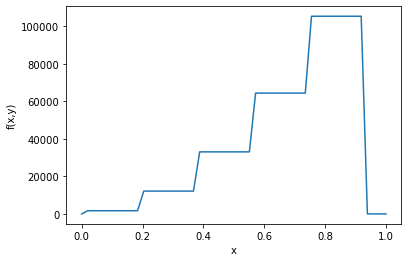

In [44]:
#######################################################################################
## SET CONSTRAINTS 
#######################################################################################

print("     ") 
print("05 SET CONSTRAINTS ")
print("     ") 



Cbar = .5
alpha = .1
cstar= alpha/10
L = 1
C = .005 
n = X.shape[0]
print("    ")
print("    ")
print("Parameters are as follow >> ")
print("    ")
print("* Cbar: ",Cbar)
print("    ")
print("* alpha: ",alpha)
print("    ")
print("* cstar: ",cstar)
print("    ")
print("* L: ",L)
print("    ")
print("* C: ",C)
print("    ")
print("* n: ",n)
print("    ")





#######################################################################################
## APPLY DENSITY FUNCTION 
#######################################################################################

print("     ") 
print("06 Apply Density Function ")
print("     ") 


# Density estimator function
funs_test = our_algo_2(n,X,alpha,L,C,Cbar,cstar)

# Apply density function to 1d arrays x,y (that both belong to [0,1])
x = np.linspace(0,1)
y = np.linspace(0,1)
#X_1 = [x,y]
test_density = list(map(funs_test,x,y))




#######################################################################################
## PLOT OF 2D DENSITY FUNCTION WITH FIRST COORDINATE x
#######################################################################################


print("     ") 
print("07 PLOT OF 2D DENSITY FUNCTION WITH FIRST COORDINATE x")
print("     ") 


plt.plot(x,test_density)
plt.xlabel("x");
plt.ylabel("f(x,y)");
plt.show();



In [45]:
print("   ")
print("--- %s seconds ---" % (time.time() - start_time))
print("   ")
print("You made it 🚀")

   
--- 0.3622438907623291 seconds ---
   
You made it 🚀
